# Classify Different Dog Breeds Using Transfer Learning and TensorFlow

Who's that doggy in the window?

Dogs are incredible. But have you ever been sitting at a cafe, seen a dog and not known what breed it is? I have. And then someone says, "it's an English Terrier" and you think, how did they know that?

In this project we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.


This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

We're going to go through the following TensorFlow/Deep Learning workflow:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model.

## Import Tools

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
from IPython.display import display, Image
import datetime
import os
from sklearn.model_selection import train_test_split

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.5.0
Hub version: 0.12.0


In [8]:
# Checkout the labels of our data
labels_csv = pd.read_csv("data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     a7ede45f2bcc3b5f918cf6626da1be91  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


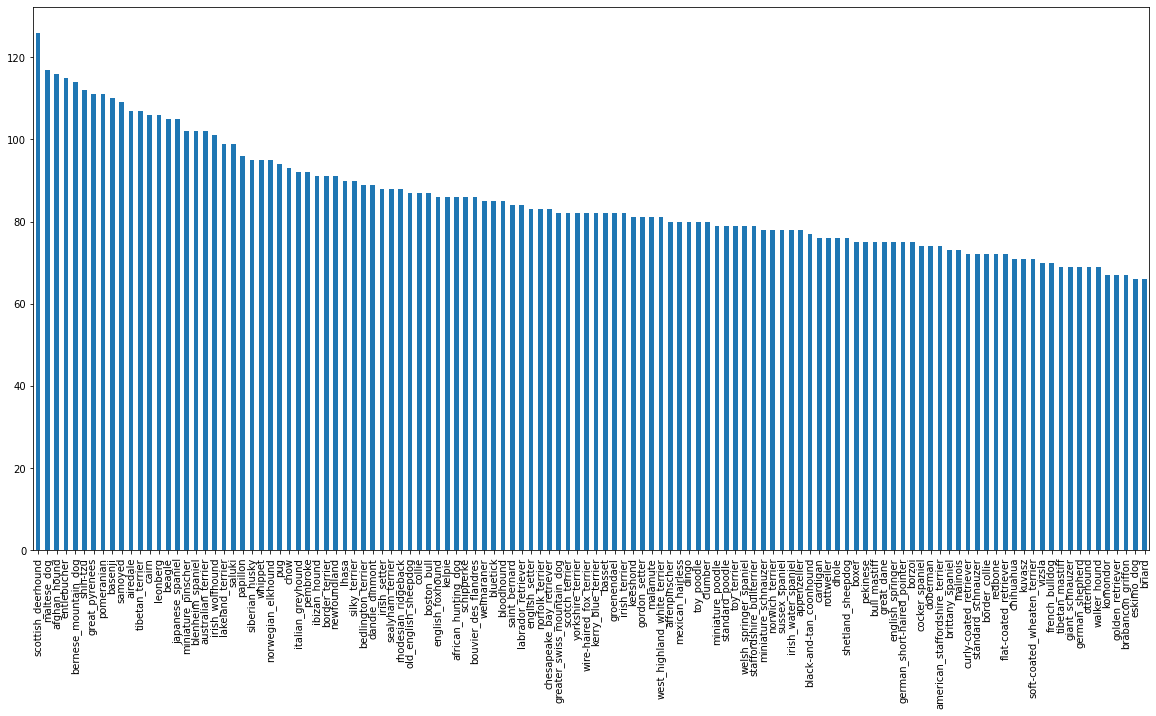

In [9]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

We'd see there's about 60+ images for each dog breed.

## Getting Images and Their Labels

Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:

* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [10]:
# Create pathnames from image ID's
filenames = ["data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

Now we've got a list of all the filenames from the ID column of `labels_csv`, we can compare it to the number of files in our training data directory to see if they line up.

In [11]:
# Check whether number of filenames matches number of actual image files
if len(os.listdir("data/train/")) == len(filenames):
    print("Filenames match actual amount of files!")
else:
    print("Filenames do not match actual amount of files, check the traget directory.")

Filenames match actual amount of files!


So everything worked, do more check, visualizing directly from a filepath.

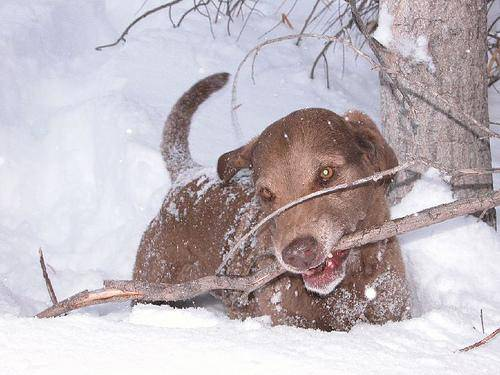

In [12]:
# Check an image directly from a filepath
Image(filenames[1611])

Now we've got our image filepaths together, let's get the labels.

We'll take them from `labels_csv` and turn them into a NumPy array.

In [13]:
labels = labels_csv["breed"].to_numpy() # Convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

Do more check, compare the amount of labels to number of filenames.

In [14]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


So all work well, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers. 

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

In [15]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

The length of `unique_breeds` should be 120, meaning we're working with images of 120 different breeds of dogs.

Now use `unique_breeds` to help turn our `labels` array into an array of booleans.

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
# Check
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Now we've got our labels in a numeric format and our image filepaths easily accessible (they aren't numeric yet), let's split our data up.

## Creating Our Own Validation Set

Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set).

Use Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to `X` (data) and our labels to `y`. 

In [17]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

In [18]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000
NUM_IMAGES

1000

Now split our data into training and validation sets. We'll use and 80/20 split (80% training data, 20% validation data).

In [19]:
# Split into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [20]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocessing Images (Turning Images Into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.

In [21]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
    """
    Takes an image file path and turns it into a Tensor.
    """
    # Read in image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-225 values to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired size (224, 224)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

## Creating Data Batches

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

In [22]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

We've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Because we'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because [according to Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?s=20) (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [23]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels).
    """

    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # Only filepaths
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data if a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                  tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        # If the data is a training dataset, we shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                  tf.constant(y))) # labels
        
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [24]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [25]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels)

## Visualizing Data Batches

In [26]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays 25 images from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(15, 15))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn gird lines off
        plt.axis("off")

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

**Note:** Running the cell below and loading images may take a little while.

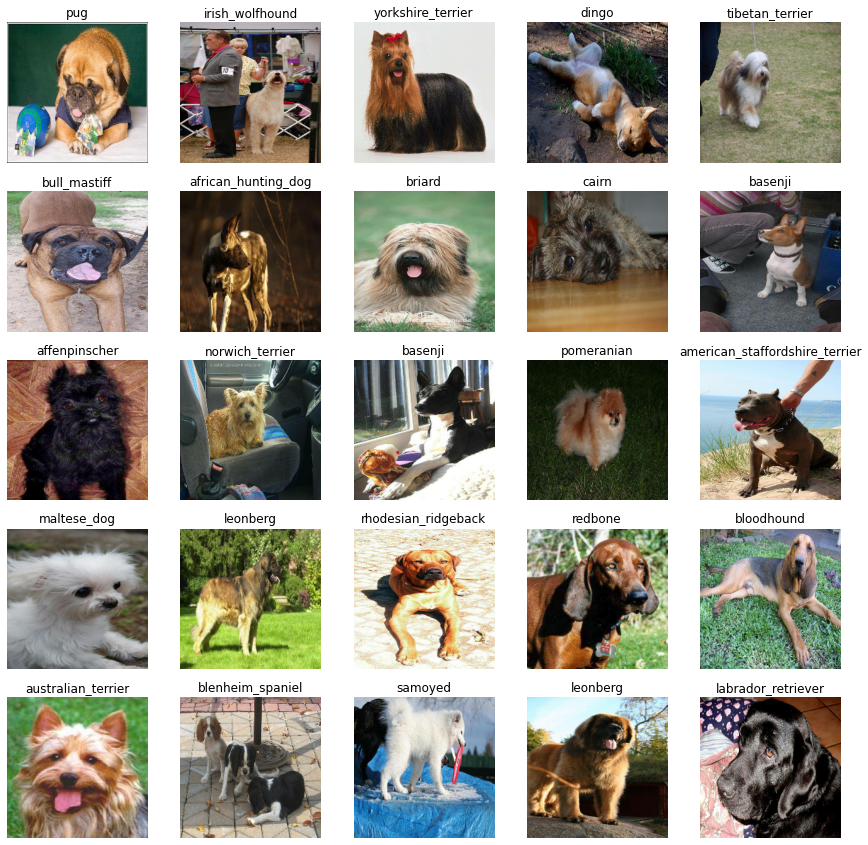

In [27]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

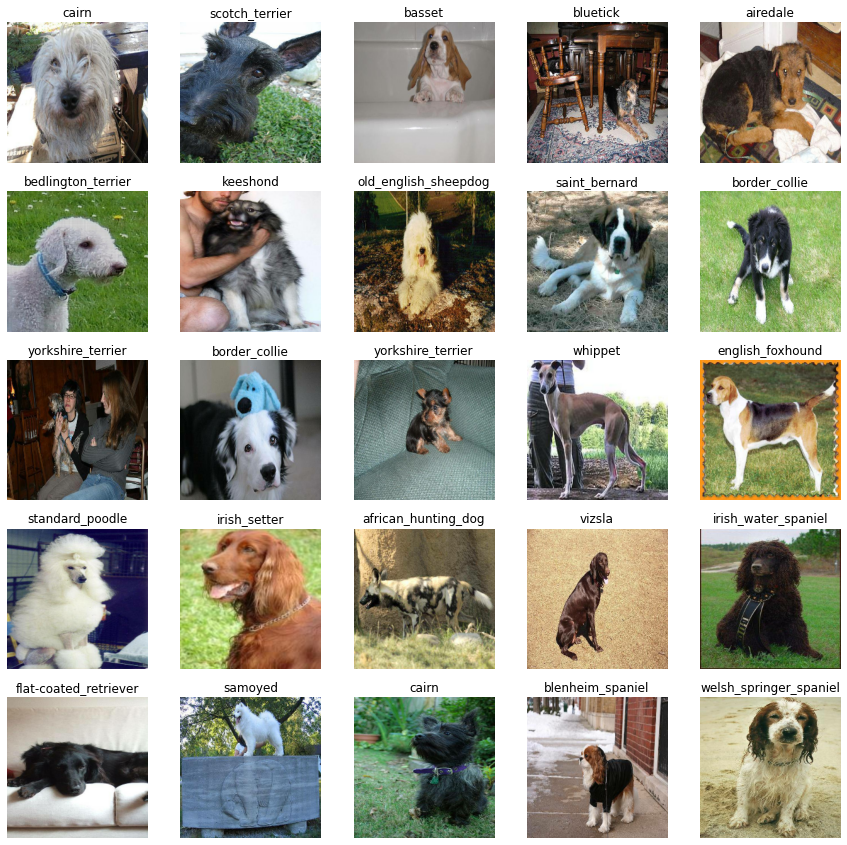

In [28]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Creating and Training a Model

Now our data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as **transfer learning**.

#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

#### How do we choose a model?

Since we know our problem is image classification (classifying different dog breeds), we can navigate the [TensorFlow Hub page by our problem domain (image)](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent). 

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, [image classification](https://tfhub.dev/s?module-type=image-classification).

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

In [29]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

We've got the inputs, outputs and model we're using ready to go.

There are many ways of building a model in TensorFlow but one of the best ways to get started is to [use the Keras API](https://www.tensorflow.org/guide/keras/overview).

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.

In [30]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation="softmax") # Layer 2 (output layer)
    ])
    
    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
        optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
        metrics=["accuracy"] # We'd like this to go up
    )

    # Build the model
    model.build(INPUT_SHAPE) # Let the model know what kind if inputs it'll be getting

    return model 

## Setting Up the Model Layers

The first layer we use is the model from TensorFlow Hub (`hub.KerasLayer(MODEL_URL)`. So our first layer is actually an entire model (many more layers). This **input layer** takes in our images and finds patterns in them based on the patterns [`mobilenet_v2_130_224`](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5) has found.

The next layer (`tf.keras.layers.Dense()`) is the **output layer** of our model. It brings all of the information discovered in the input layer together and outputs it in the shape we're after, 120 (the number of unique labels we have).

The `activation="softmax"` parameter tells the output layer, we'd like to assign a probability value to each of the 120 labels [somewhere between 0 & 1](https://en.wikipedia.org/wiki/Softmax_function). The higher the value, the more the model believes the input image should have that label. If we were working on a binary classification problem, we'd use `activation="sigmoid"`.

## Compiling the Model

Transferring this to `model.compile()` terminology:

* `loss` - The height of the hill is the loss function, the models goal is to minimize this, getting to 0 (the bottom of the hill) means the model is learning perfectly.
* `optimizer` - Your friend Adam is the optimizer, he's the one telling you how to navigate the hill (lower the loss function) based on what you've done so far. His name is Adam because the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is a great general which performs well on most models. Other optimizers include [RMSprop](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop) and [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
* `metrics` - This is the onlooker at the bottom of the hill rating how well your perfomance is. Or in our case, giving the accuracy of how well our model is predicting the correct image label.

## Building the Model

We use `model.build()` whenever we're using a layer from TensorFlow Hub to tell our model what input shape it can expect.

In this case, the input shape is `[None, IMG_SIZE, IMG_SIZE, 3]` or `[None, 224, 224, 3]` or `[batch_size, img_height, img_width, color_channels]`.

Batch size is left as `None` as this is inferred from the data we pass the model. In our case, it'll be 32 since that's what we've set up our data batches as.

In [31]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


The non-trainable parameters are the patterns learned by `mobilenet_v2_130_224` and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

## Creating Callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

### TensorBoard Callback 

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:

1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [32]:
# Load the TensorBoard notebook extension
%load_ext tensorboard 

In [33]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join("data/logs",
                          # Make it so the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

In [34]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # Stops after 3 rounds of no improvements

## Training a model (On a Subset of Data)

Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If `NUM_EPOCHS=1`, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for `NUM_EPOCHS`?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

In [35]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100

The function will:

* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [36]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1, # Check validation metrics every epoch
              callbacks=[tensorboard, early_stopping])

    return model

**Note:** When training a model for the first time, the first epoch will take a while to load compared to the rest. This is because the model is getting ready and the data is being initialised. Using more data will generally take longer, which is why we've started with ~1000 images. After the first epoch, subsequent epochs should take a few seconds.

In [37]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 28s 988ms/step - loss: 4.4392 - accuracy: 0.1088 - val_loss: 3.3061 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 21s 854ms/step - loss: 1.5656 - accuracy: 0.6913 - val_loss: 2.1353 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 21s 850ms/step - loss: 0.5269 - accuracy: 0.9513 - val_loss: 1.6899 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 18s 738ms/step - loss: 0.2451 - accuracy: 0.9900 - val_loss: 1.4999 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 18s 738ms/step - loss: 0.1423 - accuracy: 0.9987 - val_loss: 1.4359 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 21s 828ms/step - loss: 0.0979 - accuracy: 1.0000 - val_loss: 1.3900 - val_accuracy: 0.6500
Epoch 7/100
25/25 [========================

**Question:** It looks like our model might be overfitting (getting far better results on the training set than the validation set), what are some ways to prevent model overfitting? 

Hint: this may involve searching something like "ways to prevent overfitting in a deep learning model?".

**Note:** Overfitting to begin with is a good thing. It means our model is learning something.

### Checking the TensorBoard Logs

Our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

In [60]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir data/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9133), started 0:00:00 ago. (Use '!kill 9133' to kill it.)

Thanks to our `early_stopping` callback, the model stopped training after 26 or so epochs (in my case, yours might be slightly different). This is because the validation accuracy failed to improve for 3 epochs.

But the good new is, we can definitely see our model is learning something. The validation accuracy got to 65% in only a few minutes.

This means, if we were to scale up the number of images, hopefully we'd see the accuracy increase.

## Making and Evaluating Predictions Using a Trained Model

Making predictions with a trained model is as calling `predict()` on it and passing it data in the same format the model was trained on.

In [39]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 6s 627ms/step


array([[6.4686006e-03, 1.5366772e-04, 2.1252721e-03, ..., 1.7519663e-04,
        4.6341363e-05, 1.1636219e-02],
       [1.4643489e-03, 2.5082621e-04, 2.8618343e-02, ..., 8.5396873e-04,
        3.8030017e-03, 5.4652723e-05],
       [8.1814424e-06, 3.2054195e-05, 4.1543404e-04, ..., 2.9282113e-05,
        3.1487587e-05, 5.2368973e-04],
       ...,
       [1.4782916e-05, 5.3191630e-05, 6.3001484e-05, ..., 5.4039197e-06,
        2.5906553e-05, 2.2454586e-04],
       [5.2066245e-03, 8.6932014e-05, 1.5317078e-04, ..., 2.8085892e-04,
        1.6458610e-04, 1.8229188e-03],
       [1.9075209e-03, 1.7524606e-05, 5.0643814e-04, ..., 4.6602259e-03,
        2.2298105e-04, 7.8315898e-05]], dtype=float32)

In [40]:
# Check the shape of predictions
predictions.shape

(200, 120)

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (200 images) returns an array (`predictions`) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

In [41]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # The max probability value predictied by the model
print(f"Sum: {np.sum(predictions[0])}") # Because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # The index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # The predicted label

[6.4686006e-03 1.5366772e-04 2.1252721e-03 1.4252128e-04 3.2019056e-03
 4.7288904e-05 3.0425405e-02 4.4997246e-04 1.8575911e-05 1.1277534e-03
 3.7535271e-04 2.2096004e-04 3.4237991e-04 1.8428796e-04 4.8804839e-04
 1.0612020e-04 6.5662789e-05 1.3233589e-01 1.1595665e-05 4.4618871e-05
 3.7277266e-03 9.6010270e-05 2.3757002e-05 7.6003169e-04 4.3186705e-05
 5.6299096e-04 2.1170098e-01 1.8470072e-04 5.9810345e-04 9.2732289e-04
 2.0016156e-04 9.3336898e-04 1.7704632e-03 1.1502854e-04 1.3690050e-04
 4.0461607e-02 1.1000784e-05 1.9071848e-04 2.6353684e-04 3.9943820e-04
 8.1009022e-04 3.1431240e-04 9.8083568e-05 1.2758699e-04 1.9094841e-05
 9.2141294e-05 6.0371403e-05 3.3501401e-05 1.8605733e-03 1.3572974e-04
 2.4841260e-04 1.2358523e-04 1.3156231e-03 1.3114685e-04 2.3659872e-04
 7.9268597e-05 2.1273120e-04 6.9454633e-02 1.2883668e-04 1.3401712e-01
 7.0518616e-04 8.2371604e-05 1.9891409e-03 5.3183230e-06 1.3788392e-04
 4.9702547e-02 2.7688232e-04 7.0287014e-04 1.6420437e-02 8.0538201e-05
 1.294

Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

**Note:** Prediction probabilities are also known as confidence levels.

In [42]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

We've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

The model hasn't trained on the validation data, during the `fit()` function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (`val_data`) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

In [43]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels.
    """
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

We've got ways to get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

And then make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [44]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth label and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the predictions is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                        np.max(pred_prob)*100,
                                        true_label),
                                        color=color)

Making functions to help visual your models results are really helpful in understanding how your model is doing.

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Then build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [45]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

Now we've got some functions to help us visualize our predictions and evaluate our model.

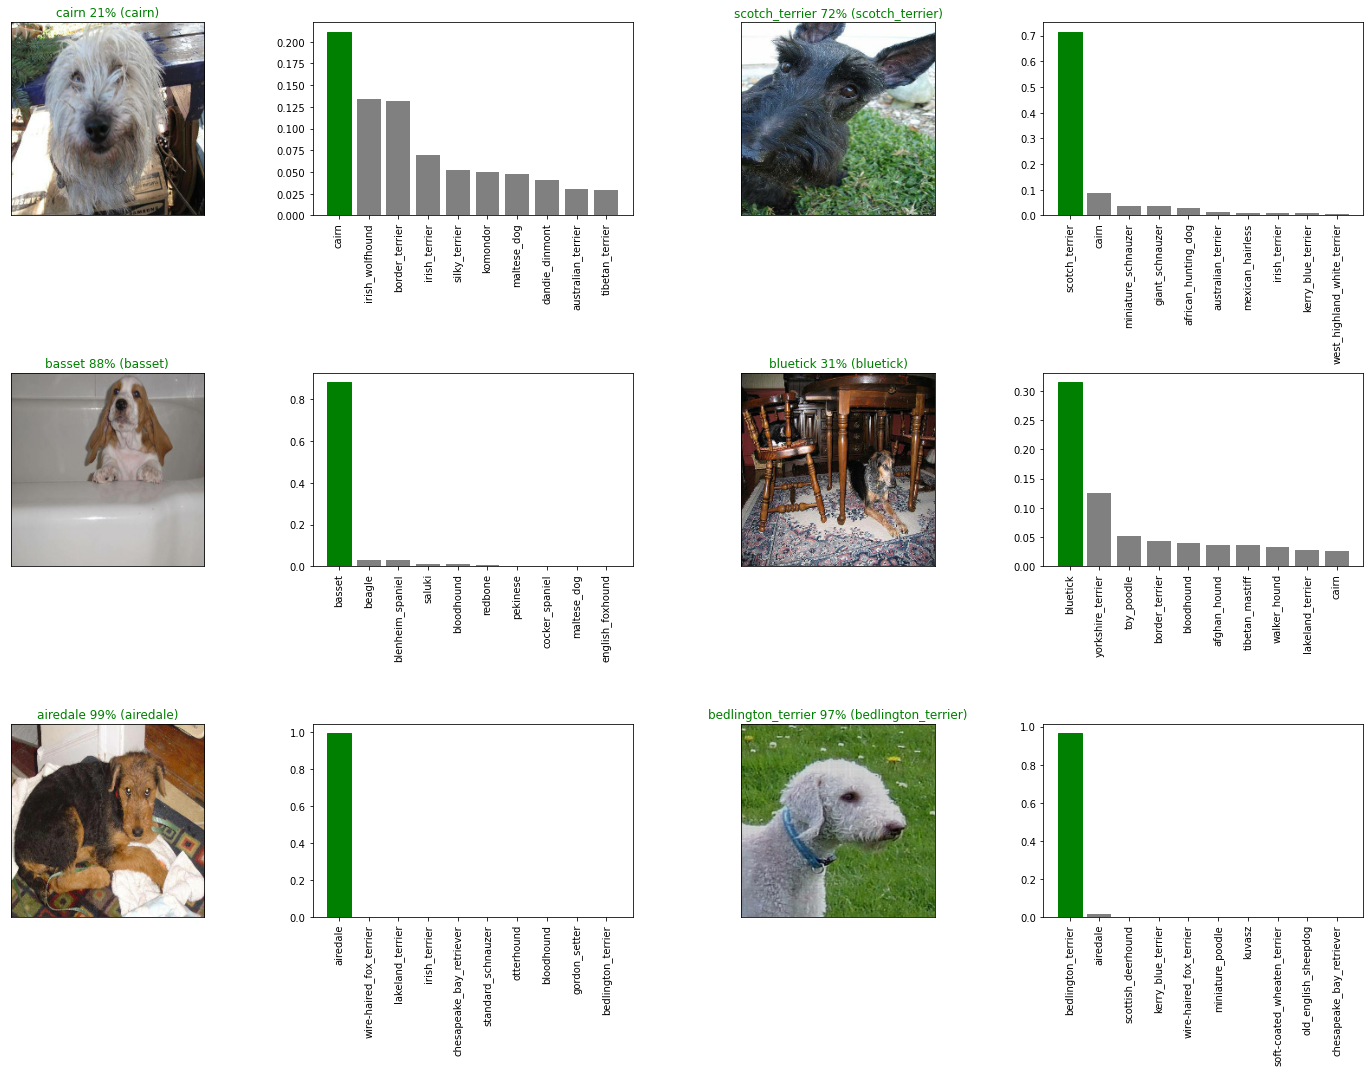

In [46]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and Reloading a Model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an [entire saved Keras model is h5](https://www.tensorflow.org/tutorials/keras/save_and_load). So we'll make a function which can take a model as input and utilise the [`save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) method to save it as a h5 file to a specified directory.

In [47]:
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (str)
    for clarity and reuse.
    """
    # Create model directory with current time
    modeldir = os.path.join("data/models",
                             datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5" # Save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

If we've got a saved model, we'd like to load it, let's create a function which can take a model path and use the [`tf.keras.models.load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) function to load it into the notebook.

Because we're using a component from TensorFlow Hub (`hub.KerasLayer`) we'll have to pass this as a parameter to the `custom_objects` parameter.

In [48]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [49]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: data/models/20210618-23141624050899-1000-images-Adam.h5...


'data/models/20210618-23141624050899-1000-images-Adam.h5'

In [50]:
# Load our model trained on 1000 images
model_1000_images = load_model("data/models/20210618-20541624042471-1000-images-Adam.h5")

Loading saved model from: data/models/20210618-20541624042471-1000-images-Adam.h5


Compare the two models (the original one and loaded one). We can do so easily using the `evaluate()` method.

In [51]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 5s 707ms/step - loss: 1.3044 - accuracy: 0.6550


[1.3043828010559082, 0.6549999713897705]

In [52]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 6s 682ms/step - loss: 1.2908 - accuracy: 0.6650


[1.290814995765686, 0.6650000214576721]

## Training a Model (On the Full Data)

We saved all of the training filepaths to `X` and all of the training labels to `y`. Let's check them out.

In [53]:
# Check of the size of the full dataset
len(X), len(y)

(10222, 10222)

We've got over 10,000 images and labels in our training set.

Before we can train a model on these, we'll have to turn them into a data batch.

The beautiful thing is, we can use our `create_data_batches()` function from above which also preprocesses our images for us (thank you past us for writing a helpful function).

In [54]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


Our data is in a data batch, all we need now is a model.

And, we've got a function for that too! Let's use `create_model()` to instantiate another model. 

In [55]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


Since we've made a new model instance, `full_model`, we'll need some callbacks too.

In [56]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

To monitor the model whilst it trains, we'll load TensorBoard (it should update every 30-seconds or so whilst the model trains).

In [57]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir data/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9099), started 0:00:33 ago. (Use '!kill 9099' to kill it.)

**Note:** Since running the cell below will cause the model to train on all of the data (10,000+) images, it may take a fairly long time to get started and finish. However, thanks to our `full_model_early_stopping` callback, it'll stop before it starts going too long.

Remember, the first epoch is always the longest as data gets loaded into memory. After it's there, it'll speed up.

In [61]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 229s 714ms/step - loss: 0.2361 - accuracy: 0.9379
Epoch 2/100
320/320 [==============================] - 217s 677ms/step - loss: 0.1547 - accuracy: 0.9627
Epoch 3/100
320/320 [==============================] - 213s 664ms/step - loss: 0.1060 - accuracy: 0.9782
Epoch 4/100
320/320 [==============================] - 211s 660ms/step - loss: 0.0763 - accuracy: 0.9862
Epoch 5/100
320/320 [==============================] - 215s 672ms/step - loss: 0.0581 - accuracy: 0.9926
Epoch 6/100
320/320 [==============================] - 206s 645ms/step - loss: 0.0464 - accuracy: 0.9938
Epoch 7/100
320/320 [==============================] - 204s 637ms/step - loss: 0.0384 - accuracy: 0.9956
Epoch 8/100
320/320 [==============================] - 207s 647ms/step - loss: 0.0313 - accuracy: 0.9969
Epoch 9/100
320/320 [==============================] - 216s 675ms/step - loss: 0.0264 - accuracy: 0.9978
Epoch 10/100
320/320 [==============================] -

## Saving and Reloading the Full Model

We can do so using our `save_model()` function.

In [62]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: data/models/20210619-00271624055242-all-images-Adam.h5...


'data/models/20210619-00271624055242-all-images-Adam.h5'

In [63]:
# Load in the full model
loaded_full_model = load_model("data/models/20210619-00271624055242-all-images-Adam.h5")

Loading saved model from: data/models/20210619-00271624055242-all-images-Adam.h5


## Making Predictions on the Test Dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [64]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['data/test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'data/test/dae9fd18836d8df20989ef0101771d4b.jpg',
 'data/test/079a40f22b0fad9a66f76797b62bb930.jpg',
 'data/test/ab8462f9a501d362041d47582fddc9ad.jpg',
 'data/test/8895089b432e020cc42e6262b5a1c2dd.jpg',
 'data/test/985ae7fc271ac4a0d131e546c0f95bb6.jpg',
 'data/test/77c1ab99cffb817d54fb14f229aeb118.jpg',
 'data/test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'data/test/d61a09cecf56666cdb315ebce4b93c43.jpg',
 'data/test/cb120c57904e8c0694bbe259c58a873c.jpg']

In [65]:
# How many test images are there?
len(test_filenames)

10357

In [66]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


**Note:** Since there are 10,000+ test images, making predictions could take a while.

In [67]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 203s 625ms/step


In [68]:
# Check out the test predictions
test_predictions[:10]

array([[2.00859454e-10, 5.61035040e-06, 2.56940536e-09, ...,
        1.77964182e-06, 5.12715981e-10, 2.79516167e-12],
       [6.51765009e-03, 2.91536533e-04, 1.27670610e-05, ...,
        1.79561459e-06, 3.49365166e-07, 3.99992750e-08],
       [8.13369283e-08, 2.39626818e-10, 5.97807264e-12, ...,
        4.90297776e-12, 9.08537395e-12, 2.84131941e-12],
       ...,
       [3.33921909e-12, 1.71226888e-09, 6.82469303e-10, ...,
        1.14014284e-07, 2.63356732e-11, 3.01707834e-12],
       [1.53279487e-07, 5.87191898e-04, 4.27691299e-10, ...,
        1.98159289e-09, 3.20599450e-12, 4.06562339e-09],
       [1.54061670e-08, 3.99780459e-10, 2.21696395e-09, ...,
        1.24880661e-10, 1.46978840e-09, 2.32030379e-06]], dtype=float32)

## Preparing Test Dataset Predictions for Kaggle

Looking at the [Kaggle sample submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation), it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

*   Create a pandas DataFrame with an ID column as well as a column for each dog breed.
*   Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the `unique_breeds` list and the `test_predictions` list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [69]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [70]:
# Append test image ID's to predictions DataFrame
test_path = "data/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

id affenpinscher afghan_hound  \
0  266490a2b053a4a3bf68e779f28fb5a9           NaN          NaN   
1  dae9fd18836d8df20989ef0101771d4b           NaN          NaN   
2  079a40f22b0fad9a66f76797b62bb930           NaN          NaN   
3  ab8462f9a501d362041d47582fddc9ad           NaN          NaN   
4  8895089b432e020cc42e6262b5a1c2dd           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [71]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id affenpinscher afghan_hound  \
0  266490a2b053a4a3bf68e779f28fb5a9           0.0     0.000006   
1  dae9fd18836d8df20989ef0101771d4b      0.006518     0.000292   
2  079a40f22b0fad9a66f76797b62bb930           0.0          0.0   
3  ab8462f9a501d362041d47582fddc9ad           0.0          0.0   
4  8895089b432e020cc42e6262b5a1c2dd           0.0          0.0   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 0.0      0.0                            0.0    0.000001   
1            0.000013      0.0                            0.0         0.0   
2                 0.0      0.0                            0.0         0.0   
3                 0.0      0.0                            0.0         0.0   
4                 0.0      0.0                            0.0         0.0   

  australian_terrier   basenji    basset  ... toy_poodle toy_terrier  \
0                0.0       0.0  0.000107  ...        0.0         0.0   
1           0.000841       0.0       0.0  ...        0.0         0.0   
2                0.0       0.0       0.0  ...        0.0         0.0   
3                0.0       0.0       0.0  ...        0.0         0.0   
4                0.0  0.000947  0.000007  ...        0.0         0.0   

     vizsla walker_hound weimaraner welsh_springer_spaniel  \
0  0.000008          0.0        0.0                    0.0   
1       0.0     0.000019   0.000035                    0.0   
2       0.0          0.0        0.0                    0.0   
3       0.0          0.0        0.0                    0.0   
4       0.0          0.0        0.0                    0.0   

  west_highland_white_terrier   whippet wire-haired_fox_terrier  \
0                         0.0  0.000002                     0.0   
1                         0.0  0.000002                     0.0   
2                         0.0       0.0                     0.0   
3                         0.0       0.0                     0.0   
4                         0.0       0.0                     0.0   

  yorkshire_terrier  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 121 columns]

Export our predictions DataFrame to CSV so we can submit it to Kaggle.

In [72]:
preds_df.to_csv("data/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

## Making Predictions on Custom Images

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

I downloaded some dog photos from google and put it in the folder `data/dogs/`

In [73]:
# Get custom image filepaths
custom_path = "data/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [74]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [75]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

Now we've got some predictions arrays, let's convert them to labels and compare them with each image.

In [76]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['american_staffordshire_terrier', 'golden_retriever', 'bernese_mountain_dog']

In [77]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

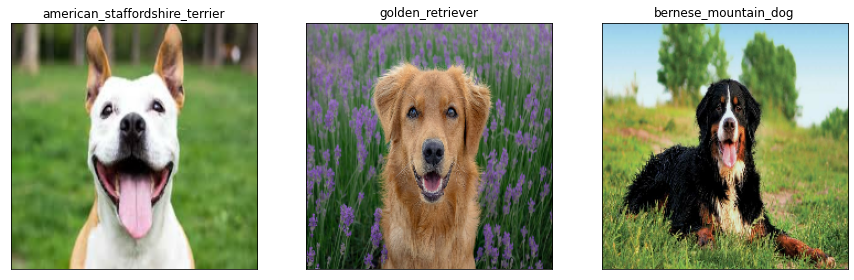

In [80]:
# Check custom image predictions
plt.figure(figsize=(15, 15))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

### Aw! So Cute!!!!

So finally we can use this model to make a custon data with our own dog photo. How cute is that?!

Thankfully the project is finished :)